In [115]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

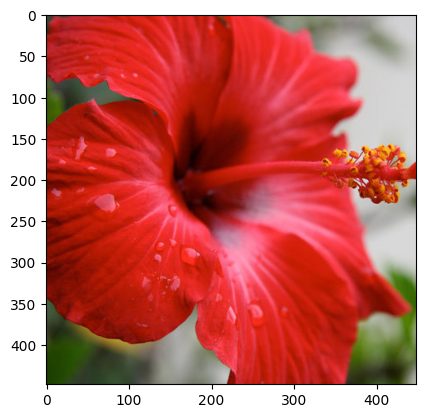

In [116]:
img_src =  cv2.cvtColor(cv2.imread('./app-data/inputs/red-hibiscus.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img_src)

In [117]:
# INPUT: desired superpixels count
K = 100
# INPUT: compactness of superpixel
m = 10 # can be in range [1, 20]

def d_lab(labxy: np.ndarray):
    return np.linalg.norm(labxy[:3])

def d_xy(labxy: np.ndarray):
    return np.linalg.norm(labxy[3:])

def Ds(first: np.ndarray, second: np.ndarray, m, S):
    diff = second - first
    return d_lab(diff) + (m / S) * d_xy(diff)

def squares_sum(vec: np.ndarray):
    return np.sum(vec**2)

def gradient(img_in: np.ndarray, point: np.ndarray):
    y, x = point
    return (
            squares_sum(
                img_in[y + 1, x] - img_in[y - 1, x]
            )
            + squares_sum(
        img_in[y, x + 1] - img_in[y, x - 1]
    )
    )

def slic(img_rgb: np.ndarray, K = 100, m=10):
    
    img_lab= cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    
    # img size
    height, width = img_src.shape[0], img_src.shape[1] 
    N = img_src.shape[0] * img_src.shape[1]
    
    # superpix cnt
    sp_cnt = N / K
    
    # grid interval
    S = int(np.sqrt(sp_cnt))
    
    ### 1: Initialize cluster centers Ck = [lk, ak, bk, xk, yk]^T by sampling pixels at regular grid steps S.
    Ck = []
    grid_interval = int(S)
    for row in range(grid_interval, height, grid_interval):
        for col in range(grid_interval, width, grid_interval):
            min_grad = np.inf
            min_grad_point = np.array([row, col])
            y_bounds = np.clip(np.array([row - 1, row + 1]), 0, height - 1)
            x_bounds = np.clip(np.array([col - 1, col + 1]), 0, width - 1)
            for dy in range(*y_bounds):
                for dx in range(*x_bounds):
                    point = np.array([dy, dx])
                    grad = gradient(img_lab, point)
                    if grad < min_grad:
                        min_grad = grad
                        min_grad_point = point
            labyx = np.array([*img_lab[*min_grad_point], *min_grad_point])
            Ck.append(labyx)
    
    closest_cluster_for = np.full((height, width, 2), [-1, np.inf])
    s2 = int(2*S)
    
    def perturbate():
        # 1. Assign the best matching pixels from a 2S × 2S square neighborhood around the cluster center according to the distance measure
        for cluster_num, cluster_center in enumerate(Ck):
            _, _, _, y, x = cluster_center
    
            y_bounds = np.clip(np.array([y - s2, y + s2]), 0, height - 1)
            x_bounds = np.clip(np.array([x - s2, x + s2]), 0, width - 1)
            
            for dy in range(*y_bounds):
                for dx in range(*x_bounds):
                    second_point = np.array([*img_lab[dy, dx], dy, dx])
                    dist = Ds(cluster_center, second_point, m, S)
                    if dist < closest_cluster_for[dy, dx, 1]:
                        closest_cluster_for[dy, dx] = (cluster_num, dist)
        
        # 2. Compute new cluster centers and residual error E {L1 distance between previous centers and recomputed centers}
        for cluster_num, cluster_center in enumerate(Ck):
            _, _, _, y, x = cluster_center
            min_grad = np.inf
            min_grad_point = np.array([row, col])
            
            y_bounds = np.clip(np.array([y - 1, y + 1]), 0, height - 1)
            x_bounds = np.clip(np.array([x - 1, x + 1]), 0, width - 1)
            
            for dy in range(*y_bounds):
                for dx in range(*x_bounds):
                    point = np.array([dy, dx])
                    grad = gradient(img_lab, point)
                    if grad < min_grad:
                        min_grad = grad
                        min_grad_point = point
            Ck[cluster_num][3:] = min_grad_point
    
    for i in range(10):
        perturbate()
    
    result = img_src.copy()

    for j in range(closest_cluster_for.shape[0] - 1):
        for i in range(closest_cluster_for.shape[1] - 1):
            if(
                closest_cluster_for[j, i, 0] != closest_cluster_for[j, i + 1, 0]
                    or
                    closest_cluster_for[j, i, 0] != closest_cluster_for[j + 1, i, 0]
            ):
                result[j, i] = (0, 0, 0)
    
    return result

<Figure size 1920x1440 with 0 Axes>

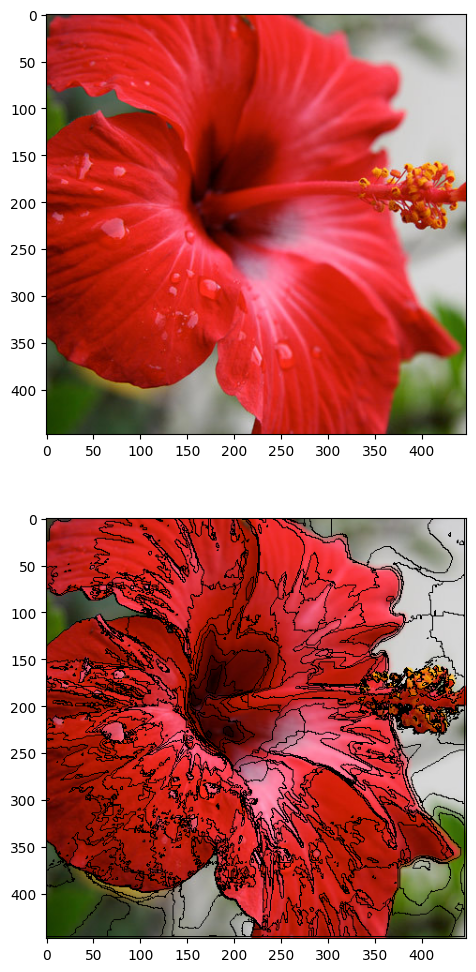

In [118]:
result = slic(img_src)

plt.figure().set_dpi(300)
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].imshow(img_src)
ax[1].imshow(result)